In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [18]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':'PJME Energy Use In MW'}, xlabel='Datetime'>

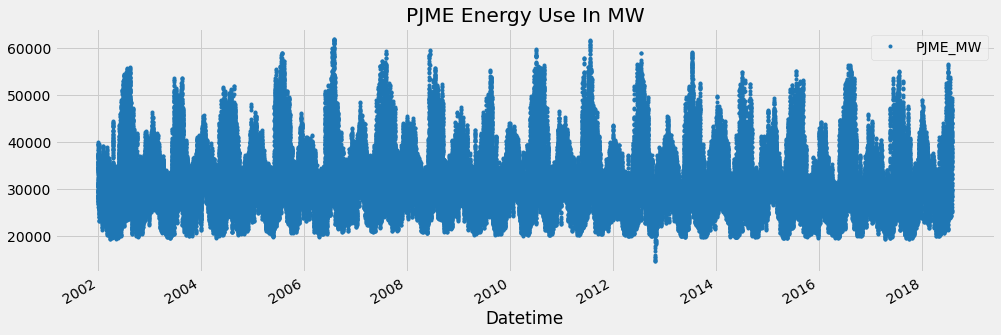

In [19]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy Use In MW')

In [20]:
# Train / Test

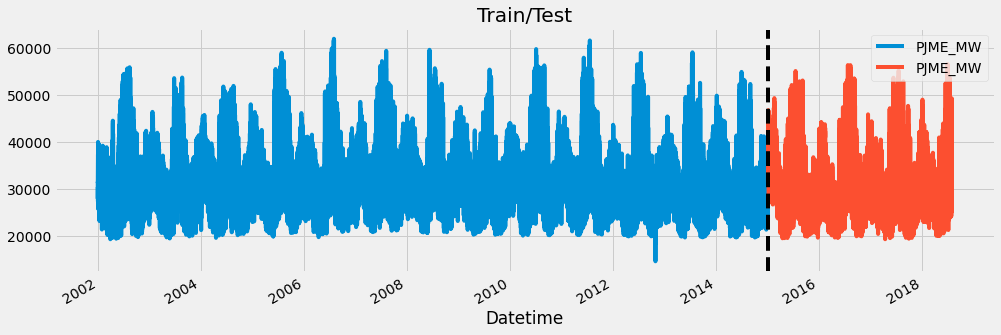

In [24]:
train = df.loc[df.index < '01-06-2015']
test = df.loc[df.index >= '01-06-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training', title='Train/Test')
test.plot(ax=ax, label='Testing')
ax.axvline('01-06-2015', color='black', ls='--')
plt.show()

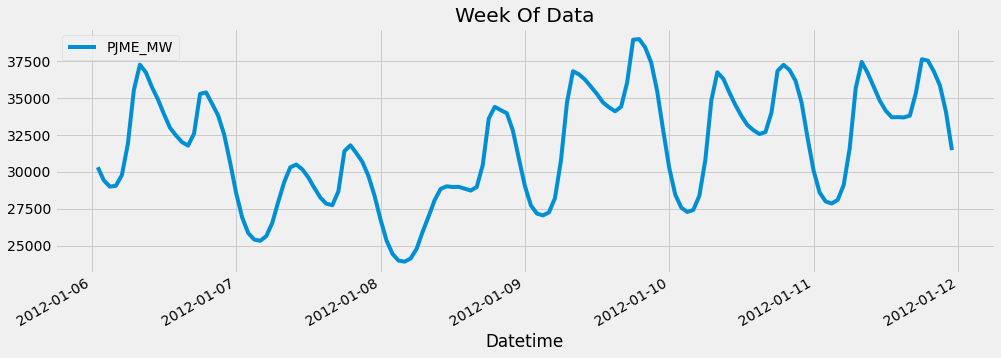

In [27]:
df.loc[(df.index > '01-06-2012') & (df.index < '01-12-2012')] \
   .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [36]:
def create_feature(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.year
    return df
df = create_feature(df)

In [37]:
#Visualizzation

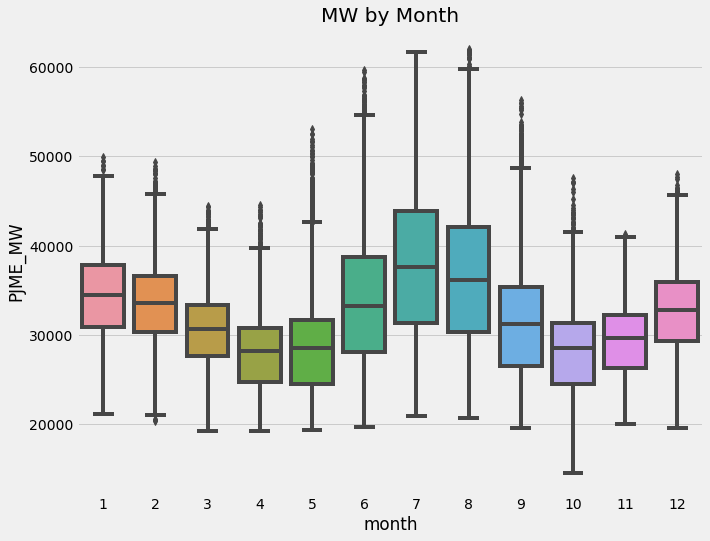

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title("MW by Month")
plt.show()

In [42]:
# Model

In [46]:
train = create_feature(train)
test = create_feature(test)

C:\Users\satyam singh\AppData\Local\Temp\ipykernel_57240\1415970227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\satyam singh\AppData\Local\Temp\ipykernel_57240\1415970227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
C:\Users\satyam singh\AppData\Local\Temp\ipykernel_57240\1415970227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [48]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [49]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET= 'PJME_MW'

In [50]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [71]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[03:30:03] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32604.02344	validation_1-rmse:31658.32227
[100]	validation_0-rmse:12602.00195	validation_1-rmse:11771.83398
[200]	validation_0-rmse:5904.33105	validation_1-rmse:5455.60449
[300]	validation_0-rmse:4059.30395	validation_1-rmse:4148.40137
[400]	validation_0-rmse:3604.67773	validation_1-rmse:3991.60767
[500]	validation_0-rmse:3460.44727	validation_1-rmse:3944.33545
[600]	validation_0-rmse:3390.51245	validation_1-rmse:3910.95288
[700]	validation_0-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
#Trained now

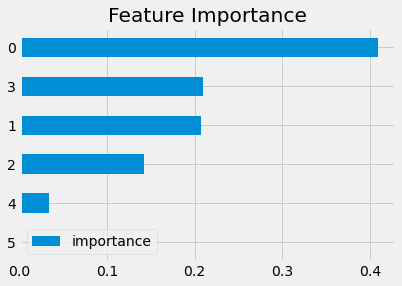

In [76]:
fi = pd.DataFrame(data=reg.feature_importances_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [77]:
#Test


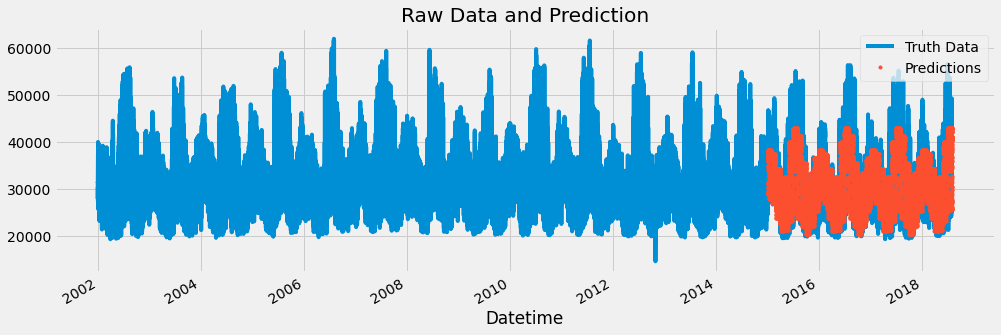

In [87]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [86]:
# df[['PJME_MW']].plot(figsize=(15, 5))
# df['prediction'].plot(ax=ax, style='.')
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Data and Predictions')
# plt.show()

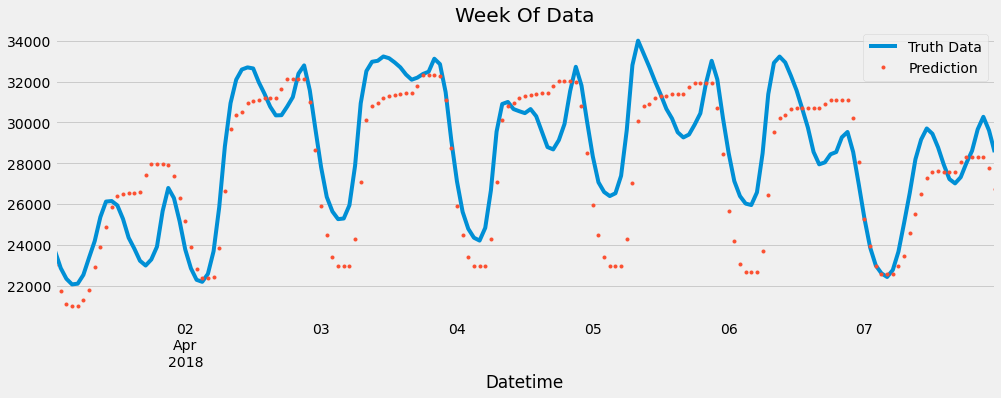

In [88]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [91]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE score on test set: {score:0.2f}')

RMSE score on test set: 3845.72


In [ ]:
#Best predictions

In [98]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).tail(5)

date
2015-10-03    438.931478
2016-10-08    412.472493
2017-10-29    402.713460
2016-10-03    297.169189
2016-10-02    269.095785
Name: error, dtype: float64

In [ ]:
#Worst predictions

In [99]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-14    13535.285238
2016-09-09    13476.516602
2016-08-13    13189.174316
2016-09-10    13006.116943
2015-09-09    11392.082845
Name: error, dtype: float64